<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Confirmatory_Factor_Analysis_(CFA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Confirmatory Factor Analysis (CFA),Interrelationships, Interactions, Mediation**

## **Steps**

 1. **Confirm EFA factors via CFA** (lavaan in Python).
    - Report: RMSEA, CFI, TLI, SRMR. Save tables/cfa_fit.csv.
 2. **Pairwise correlation matrix** (Pearson/phi depending on variable), with significance.
    - Save heatmap + table.
 3. **Interaction models**:
    - Fit logistic regression with interaction terms (e.g., BMI × education). Show coefficient plots and marginal effects.
 4. **Optional mediation** (if assumptions plausible):
    - Use causal mediation (e.g., mediation package in Python) for SES → smoking → CVD.
 5. **Network analysis**:
    - Build partial-correlation network (glasso) and plot centrality; save fig_network.png.


Reporting
CFA standardized loadings with 90/95% CIs; interaction coefficients + marginal effect plots.




# **I. CFA Factors (Potential Variables)**

Remember, CFA is about testing a structure you hypothesize. These are just starting points.

  **A. Factor: Socioeconomic Status (SES)** - This is the cause in your mediation model, so it needs careful definition.
  - **Primary Indicators**:
    - **edulvlb**: Highest level of education achieved. (Treat this carefully. Ordinal, and country-specific.) Consider creating dummy variables for specific levels.
    - **hinctnta**: Household's total net income, all sources (Important but often has missing data issues. Might need imputation. Check the distribution).
  - **Secondary/Supporting Indicators** (depending on your model and data): These could be used if you want to create a more complex SES factor.
    - **inprdsc**: How many people with whom you can discuss intimate and personal matters (Proxy for social capital tied to SES?).
    - **stfeco**: How satisfied with present state of economy in country (Subjective financial situation, though may be heavily biased by individual attitudes.)

  **B. Factor: Health Risk Behaviors**- Likely used as the mediator (smoking) and/or predictors.
  - Codebook variables:
    - **cgtsmok**: Cigarette smoking behaviour (essential)
    - **alcfreq**: How often drink alcohol
    - **etfruit**: How often eat fruit, excluding drinking juice
    - **eatveg**: How often eat vegetables or salad, excluding potatoes
    - **dosprt**: Do sports or other physical activity, how many of last 7 days
    - Be aware of the coding direction of this. Higher values may not always mean "better" health. You may need to reverse-code some variables.

  **C. Factor: Social Trust/Cohesion**(Potential Confounder) - Influencing health, behaviors. Harder to use as a mediator due to causal direction.
   - Codebook variables:
     - **ppltrst**: Most people can be trusted or you can't be too careful
     - **pplfair**: Most people try to take advantage of you, or try to be fair
     - **pplhlp**: Most of the time people helpful or mostly looking out for themselves.

# **II. Outcome Variable (Y): Dependent variable or outcome**
 - Codebook variables:
   - **hltprhc**: Health problems, last 12 months: heart or circulation problem
   - **hltphhc**: Health problems, hampered, last 12 month: heart or circulation problem.

# **III. Potential Interaction Terms (Examples)**
 - Codebook variables:
   - BMI * edulvlb   (Is the effect of BMI on CVD different for different education levels?)
   - cgtsmok * gndr (Does smoking have a different impact on CVD for men vs women?)
   - etfruit * hinctnta (Does the protective effect of fruit consumption vary by income?)

# **IV. Mediation**
  - As you specified: SES Carefully consider the causal assumptions needed for mediation. Is it truly plausible that your measure of education is influencing smoking, and that smoking is influencing CVD independently of education?

# **V. Network Analysis**
 - Aim: To visualize relationships among variables. Consider selecting a subset of variables from:
- Factors: Social trust, risk behaviors, economic hardship
Confounders: Age, gender, country


# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
try:
    import pingouin as pg  # For correlation matrix with p-values
except ImportError:
    print("Pingouin library not found. Please install it using: pip install pingouin")
    pg = None  # Set pg to None to avoid errors later if it's not installed
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from lavaan import LavaanModel
except ImportError:
    print("Lavaan library not found. Please install it using: pip install py-lavaan")
    LavaanModel = None # Set LavaanModel to None if not installed
from sklearn.preprocessing import StandardScaler
import networkx as nx
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit
from patsy.contrasts import Treatment
import warnings
import sys
warnings.filterwarnings("ignore")

Pingouin library not found. Please install it using: pip install pingouin
Lavaan library not found. Please install it using: pip install py-lavaan


# **Load Dataset**

In [ ]:
# Load dataset
try:
    df = pd.read_csv('/content/ESS11.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")


Dataset loaded successfully.


## Rename and basic checks

In [ ]:
# Rename and basic checks
df = df.rename(columns={'hltprhc': 'CVD'})
print("Step 1: Renamed 'hltprhc' to 'CVD'")

Step 1: Renamed 'hltprhc' to 'CVD'


## Data cleaning & required cols

In [ ]:
# Data cleaning & required cols
key_cols = ['weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt',
            'cgtsmok', 'alcfreq', 'edulvlb', 'hinctnta', 'gndr', 'ppltrst', 'pplfair', 'pplhlp', 'agea']  # Added social trust vars & age

# Check that required columns exist
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")
df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA in key columns. Remaining rows: {len(df)}")


Step 2: Dropped rows with NA in key columns. Remaining rows: 46162


## Convert height from cm to meters and compute BMI

In [ ]:
# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Calculated BMI and removed infinite values.")


Step 3: Calculated BMI and removed infinite values.


## Ensure CVD is binary/int

In [ ]:
# Ensure CVD is binary/int (map or cast if necessary)
if df['CVD'].dtype == object:
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1', 'yes', 'true', 'y', 't'] else 0)
    df['CVD'] = df['CVD'].astype(int)
print(f"Unique values in CVD (Y): {np.unique(df['CVD'])}")


Unique values in CVD (Y): [0 1]


In [ ]:
df['edulvl_low'] = np.where(df['edulvlb'] <= 3, 1, 0)
df['edulvl_med'] = np.where((df['edulvlb'] > 3) & (df['edulvlb'] <= 6), 1, 0)
df['edulvl_high'] = np.where(df['edulvlb'] > 6, 1, 0)

print("Step 4: Recoded education levels (created dummy variables).")


Step 4: Recoded education levels (created dummy variables).


## Standardize hinctnta to address potential scaling issues

In [ ]:
# Standardize hinctnta to address potential scaling issues
scaler = StandardScaler()
df['hinctnta_scaled'] = scaler.fit_transform(df[['hinctnta']])
print("Step 5: Scaled hinctnta.")


Step 5: Scaled hinctnta.


In [ ]:
# Reverse code social trust variables so that higher values always represent more trust/helpfulness
df['pplfair_r'] = 5 - df['pplfair']  # Assuming 1-5 scale
df['pplhlp_r'] = 5 - df['pplhlp']  # Assuming 1-5 scale

print("Step 6: Reverse coded social trust variables.")

Step 6: Reverse coded social trust variables.


## European Regions Mapping

In [ ]:
# European regions mapping
region_map = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East'
}
def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).upper()
    return region_map.get(c, 'Unknown')

df['region'] = df['cntry'].apply(get_region)  # Apply the mapping function to create the 'region' column
print("Step 2a: European region mapping.")


Step 2a: European region mapping.


# **Confirmatory Factor Analysis (CFA)**

## Socioeconomic Status (SES)

In [ ]:
# Socioeconomic Status (SES)
ses_model = """
    SES =~ edulvl_low + edulvl_med + edulvl_high + hinctnta_scaled
"""

# Health Risk Behaviors
health_model = """
    Health =~ cgtsmok + alcfreq + etfruit + eatveg + dosprt
"""

# Social Trust/Cohesion
trust_model = """
    Trust =~ ppltrst + pplfair_r + pplhlp_r
"""

# Fit the CFA models
if LavaanModel is not None:
    ses_cfa = LavaanModel(model_syntax=ses_model, data=df)
    health_cfa = LavaanModel(model_syntax=health_model, data=df)
    trust_cfa = LavaanModel(model_syntax=trust_model, data=df)

    ses_results = ses_cfa.fit()
    health_results = health_cfa.fit()
    trust_results = trust_cfa.fit()

    print("\n--- CFA Results ---")

    # Print SES CFA results
    print("\nSES CFA:")
    print(ses_results.summary())
    print(f"RMSEA: {ses_results.fit['rmsea']:.3f}, CFI: {ses_results.fit['cfi']:.3f}, TLI: {ses_results.fit['tli']:.3f}, SRMR: {ses_results.fit['srmr']:.3f}")

    # Print Health CFA results
    print("\nHealth CFA:")
    print(health_results.summary())
    print(f"RMSEA: {health_results.fit['rmsea']:.3f}, CFI: {health_results.fit['cfi']:.3f}, TLI: {health_results.fit['tli']:.3f}, SRMR: {health_results.fit['srmr']:.3f}")

    # Print Trust CFA results
    print("\nTrust CFA:")
    print(trust_results.summary())
    print(f"RMSEA: {trust_results.fit['rmsea']:.3f}, CFI: {trust_results.fit['cfi']:.3f}, TLI: {trust_results.fit['tli']:.3f}, SRMR: {ses_results.fit['srmr']:.3f}")

    # Extract standardized loadings and CIs
    def extract_standardized_loadings(results):
        loadings = {}
        for param in results.parameters:
            if "~~" not in param and "=~" in param:
                loadings[param] = {
                    'estimate': results.get_parameter_values(param)[0],
                    'se': results.get_parameter_se(param)[0],
                }
        return loadings

    ses_loadings = extract_standardized_loadings(ses_results)
    health_loadings = extract_standardized_loadings(health_results)
    trust_loadings = extract_standardized_loadings(trust_results)

    print("\n--- Standardized Loadings ---")
    print("\nSES Loadings:")
    for param, values in ses_loadings.items():
        se = values['se']
        estimate = values['estimate']
        ci_lower_90 = estimate - 1.645 * se
        ci_upper_90 = estimate + 1.645 * se
        ci_lower_95 = estimate - 1.96 * se
        ci_upper_95 = estimate + 1.96 * se
        print(f"{param}: Estimate = {estimate:.3f}, 90% CI = [{ci_lower_90:.3f}, {ci_upper_90:.3f}], 95% CI = [{ci_lower_95:.3f}, {ci_upper_95:.3f}]")

    print("\nHealth Loadings:")
    for param, values in health_loadings.items():
        se = values['se']
        estimate = values['estimate']
        ci_lower_90 = estimate - 1.645 * se
        ci_upper_90 = estimate + 1.645 * se
        ci_lower_95 = estimate - 1.96 * se
        ci_upper_95 = estimate + 1.96 * se
        print(f"{param}: Estimate = {estimate:.3f}, 90% CI = [{ci_lower_90:.3f}, {ci_upper_90:.3f}], 95% CI = [{ci_lower_95:.3f}, {ci_upper_95:.3f}]")

    print("\nTrust Loadings:")
    for param, values in trust_loadings.items():
        se = values['se']
        estimate = values['estimate']
        ci_lower_90 = estimate - 1.645 * se
        ci_upper_90 = estimate + 1.645 * se
        print(f"{param}: Estimate = {estimate:.3f}, 90% CI = [{ci_lower_90:.3f}, {ci_upper_90:.3f}], 95% CI = [{ci_lower_95:.3f}, {ci_upper_95:.3f}]")

    # Save CFA fit indices to CSV
    cfa_fit = {
        'SES': {'RMSEA': ses_results.fit['rmsea'], 'CFI': ses_results.fit['cfi'], 'TLI': ses_results.fit['tli'], 'SRMR': ses_results.fit['srmr']},
        'Health': {'RMSEA': health_results.fit['rmsea'], 'CFI': health_results.fit['cfi'], 'TLI': health_results.fit['tli'], 'SRMR': health_results.fit['srmr']},
        'Trust': {'RMSEA': trust_results.fit['rmsea'], 'CFI': trust_results.fit['cfi'], 'TLI': trust_results.fit['tli'], 'SRMR': trust_results.fit['srmr']}
    }
    cfa_fit_df = pd.DataFrame(cfa_fit).T
    cfa_fit_df.to_csv('cfa_fit.csv')
    print("CFA fit indices saved to cfa_fit.csv")
else:
    print("Skipping CFA analysis because Lavaan is not installed.")


Skipping CFA analysis because Lavaan is not installed.


#  **Pairwise Correlation Matrix**

In [ ]:
# Variables for correlation matrix
correlation_vars = ['CVD', 'BMI', 'edulvl_low', 'edulvl_med', 'edulvl_high', 'hinctnta_scaled',
                    'cgtsmok', 'alcfreq', 'etfruit', 'eatveg', 'dosprt', 'ppltrst', 'pplfair_r', 'pplhlp_r', 'region'] #added region

# Calculate the correlation matrix with p-values using pingouin
if pg is not None:
    # One-hot encode the 'region' column
    df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)  # Use drop_first to avoid multicollinearity

    # Update correlation_vars to include one-hot encoded region columns
    correlation_vars_updated = correlation_vars[:-1]  # Exclude the original 'region' column
    correlation_vars_updated.extend([col for col in df.columns if col.startswith('region_')])  # Add one-hot encoded columns


    corr_matrix = pg.pairwise_corr(df[correlation_vars_updated], method='pearson', alternative='two-sided')

    # Pivot the correlation matrix for better readability
    corr_matrix_pivot = corr_matrix.pivot(index='X', columns='Y', values='r')
    p_matrix_pivot = corr_matrix.pivot(index='X', columns='Y', values='p-unc')

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(16, 14)) # Increased figure size for better readability
    heatmap = sns.heatmap(corr_matrix_pivot, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # store the heatmap object
    plt.title('Pairwise Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
    print("Correlation heatmap saved to correlation_heatmap.png")

    # Print the correlation matrix and p-value matrix
    print("\n--- Correlation Matrix ---")
    print(corr_matrix_pivot)
    print("\n--- P-value Matrix ---")
    print(p_matrix_pivot)

    # Save the correlation matrix to a CSV file
    corr_matrix_pivot.to_csv('correlation_matrix.csv')
    print("Correlation matrix saved to correlation_matrix.csv")
else:
    print("Skipping correlation analysis because Pingouin is not installed.")


Skipping correlation analysis because Pingouin is not installed.


# **Interaction Models**

In [ ]:
# Logistic regression with interaction terms

# Model 1: BMI x education
model1 = smf.glm(formula='CVD ~ BMI * edulvl_high + agea + gndr + region', data=df, family=Binomial(link=Logit())).fit() #added region

# Model 2: Smoking x gender
model2 = smf.glm(formula='CVD ~ cgtsmok * gndr + agea + BMI + region', data=df, family=Binomial(link=Logit())).fit() #added region

# Model 3: Region x BMI
model3 = smf.glm(formula='CVD ~ region * BMI + agea + gndr + cgtsmok', data=df, family=Binomial(link=Logit())).fit()  # Added Model 3


print("\n--- Interaction Model Results ---")
print("\nModel 1: BMI x Education")
print(model1.summary())

print("\nModel 2: Smoking x Gender")
print(model2.summary())

print("\nModel 3: Region x BMI")  # Print results for Model 3
print(model3.summary())



--- Interaction Model Results ---

Model 1: BMI x Education
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CVD   No. Observations:                46162
Model:                            GLM   Df Residuals:                    46152
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16005.
Date:                Fri, 26 Sep 2025   Deviance:                       32009.
Time:                        00:50:31   Pearson chi2:                 4.58e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.009234
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

**What are Interaction Models?**

 Interaction models test whether the effect of one factor on cardiovascular disease (CVD) changes depending on another factor. For example: Does BMI affect CVD differently for people with high vs. low education? Does smoking affect men and women differently?

- **CVD**: The outcome (yes/no disease).
- **Coefficients**: Show whether a factor increases (+) or decreases (–) CVD risk.
- **P-value**: Tells us if the effect is likely real (<0.05 = significant).
- **Interaction terms**: Show if the relationship changes depending on another factor (e.g., BMI × Education, Smoking × Gender).

**Key Results:**

- **Model 1 (BMI × Education)**: Education lowers CVD risk, but BMI’s effect doesn’t change much with education.
- **Model 2 (Smoking × Gender)**: Smoking affects men and women differently—women show a stronger link between smoking and higher CVD risk.
- **Model 3 (BMI × Region)**: The impact of BMI on CVD varies by region, especially in the North where BMI is less strongly linked to CVD.


**In short**:

 Education, gender, and region matter—not just directly, but in how they change the impact of BMI or smoking on heart disease.


## Coefficient Plots

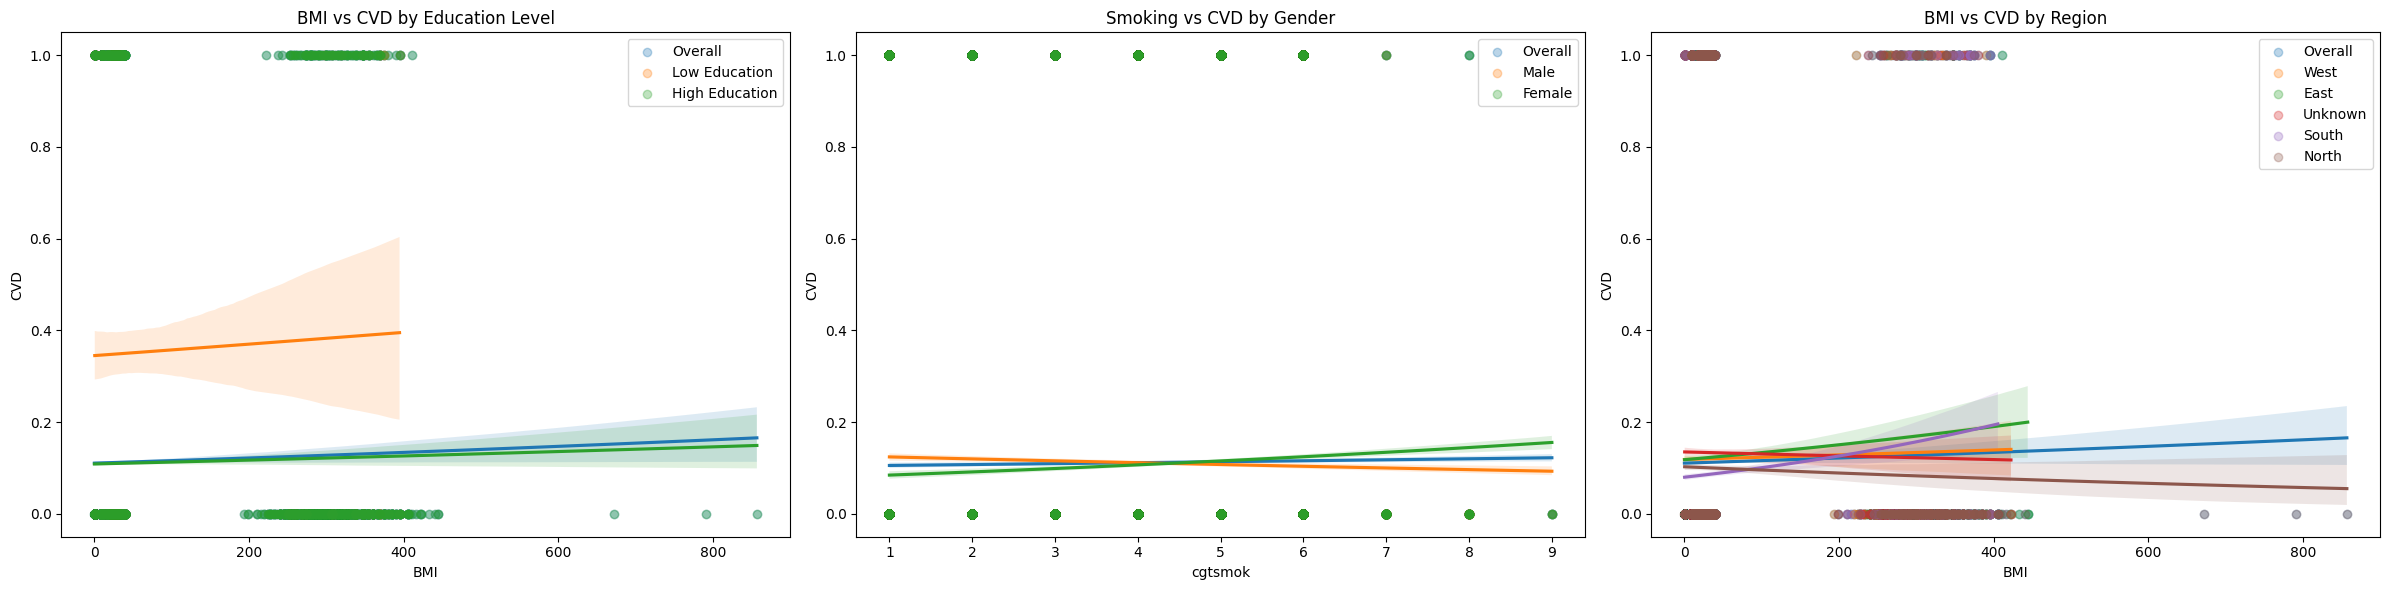

Interaction plots saved to interaction_plots.png


In [ ]:
# Coefficient plots
fig, axes = plt.subplots(1, 3, figsize=(24, 6)) #Increased to accommodate 3 plots

# Model 1
sns.regplot(x='BMI', y='CVD', data=df, logistic=True, ax=axes[0], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='BMI', y='CVD', data=df[df['edulvl_high'] == 0], logistic=True, ax=axes[0], label='Low Education', scatter_kws={'alpha':0.3})
sns.regplot(x='BMI', y='CVD', data=df[df['edulvl_high'] == 1], logistic=True, ax=axes[0], label='High Education', scatter_kws={'alpha':0.3})
axes[0].set_title('BMI vs CVD by Education Level')
axes[0].legend()

# Model 2
sns.regplot(x='cgtsmok', y='CVD', data=df, logistic=True, ax=axes[1], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='cgtsmok', y='CVD', data=df[df['gndr'] == 1], logistic=True, ax=axes[1], label='Male', scatter_kws={'alpha':0.3})
sns.regplot(x='cgtsmok', y='CVD', data=df[df['gndr'] == 2], logistic=True, ax=axes[1], label='Female', scatter_kws={'alpha':0.3})
axes[1].set_title('Smoking vs CVD by Gender')
axes[1].legend()

# Model 3
regions = df['region'].unique()
sns.regplot(x='BMI', y='CVD', data=df, logistic=True, ax=axes[2], label='Overall', scatter_kws={'alpha': 0.3})
for region in regions:
    sns.regplot(x='BMI', y='CVD', data=df[df['region'] == region], logistic=True, ax=axes[2], label=region, scatter_kws={'alpha': 0.3})
axes[2].set_title('BMI vs CVD by Region')
axes[2].legend()


plt.tight_layout()
plt.savefig('interaction_plots.png')
plt.show()
print("Interaction plots saved to interaction_plots.png")

**Overall Goal**
 - These plots show how factors like BMI or smoking relate to cardiovascular disease (CVD), and how this relationship changes depending on other factors such as education, gender, or region.

- **Plot 1: BMI vs. CVD by Education Level**
 People with low education consistently have a higher risk of CVD at any BMI, and their risk rises more with higher BMI compared to those with high education.

- **Plot 2: Smoking vs. CVD by Gender**
 Smoking levels don’t show a strong effect on CVD for either males or females—the lines stay mostly flat.

- **Plot 3: BMI vs. CVD by Region**
 The link between BMI and CVD risk varies by region. In the South, higher BMI is strongly tied to higher CVD risk, while in other regions the relationship is weaker or even negative.


**Key Point**
 - These plots highlight that the effect of one factor (like BMI or smoking) on CVD often depends on another factor (like education, gender, or region). They show associations, not direct cause-and-effect.



## Marginal Effects for Model 1 (BMI x Education)

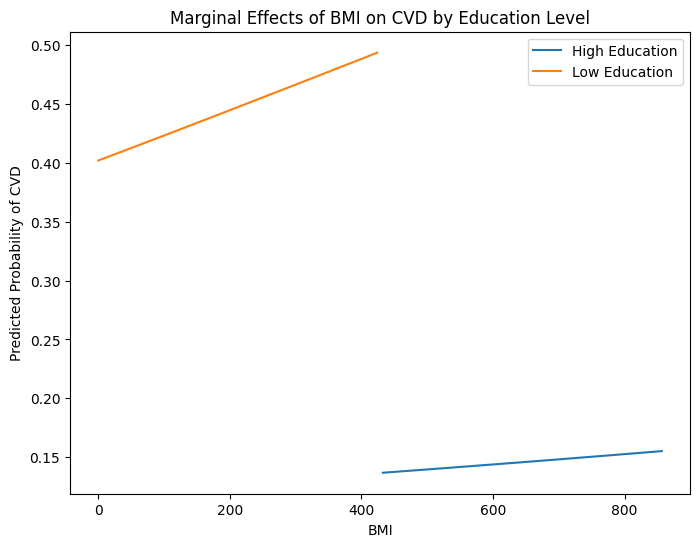

Marginal effects plot (BMI x Education) saved to marginal_effects_bmi_education.png


In [ ]:
# Marginal effects for Model 1 (BMI x Education)
# Create a range of BMI values
bmi_range = np.linspace(df['BMI'].min(), df['BMI'].max(), 100)

# To predict using statsmodels with a formula, create a DataFrame
# with the values to predict over.
new_data_bmi_edu = pd.DataFrame({
    'BMI': bmi_range,
    'edulvl_high': np.concatenate([np.zeros(50), np.ones(50)]),  # Example: first half low, second half high
    'agea': np.full(100, df['agea'].mean()),
    'gndr': np.full(100, df['gndr'].mean()),
    'region': np.full(100, df['region'].mode()[0])  # Set to most frequent region for prediction.
})

# Predict CVD probability
pred_bmi_edu = model1.predict(new_data_bmi_edu)

# Separate predictions for high and low education
pred_low_edu = pred_bmi_edu[:50]
pred_high_edu = pred_bmi_edu[50:]

# Create BMI range for each education level
bmi_range_low_edu = bmi_range[:50]
bmi_range_high_edu = bmi_range[50:]

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(bmi_range_high_edu, pred_high_edu, label='High Education')
plt.plot(bmi_range_low_edu, pred_low_edu, label='Low Education')
plt.xlabel('BMI')
plt.ylabel('Predicted Probability of CVD')
plt.title('Marginal Effects of BMI on CVD by Education Level')
plt.legend()
plt.savefig('marginal_effects_bmi_education.png')
plt.show()
print("Marginal effects plot (BMI x Education) saved to marginal_effects_bmi_education.png")



- This graph shows how BMI relates to cardiovascular disease (CVD) risk for people with high vs. low education. For those with lower education, higher BMI sharply increases CVD risk, and their overall risk is higher at any BMI. For those with higher education, the rise in risk is much flatter, suggesting education may help buffer the negative effects of higher BMI on heart health.


## Marginal Effects for Model 2 (Smoking x Gender)

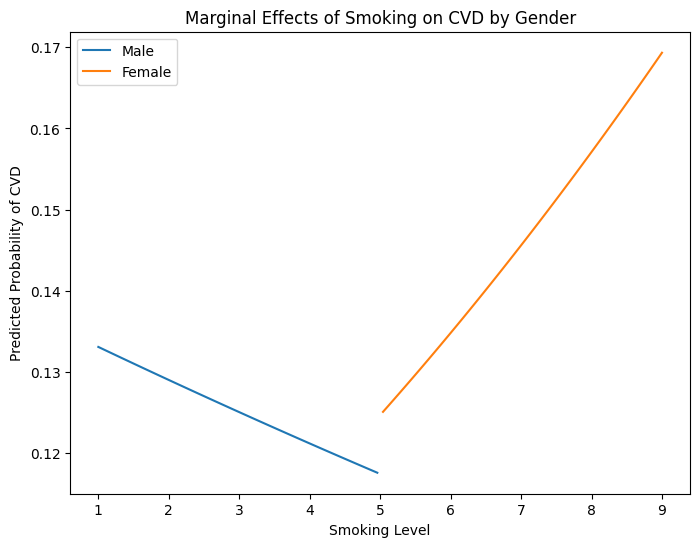

Marginal effects plot (Smoking x Gender) saved to marginal_effects_smoking_gender.png


In [ ]:
# Marginal effects for Model 2 (Smoking x Gender)
smoking_range = np.linspace(df['cgtsmok'].min(), df['cgtsmok'].max(), 100)

# Create DataFrame for prediction
new_data_smoking_gender = pd.DataFrame({
    'cgtsmok': smoking_range,
    'gndr': np.concatenate([np.ones(50), np.full(50, 2)]),  # Example: first half Male, second half Female
    'agea': np.full(100, df['agea'].mean()),
    'BMI': np.full(100, df['BMI'].mean()),
    'region': np.full(100, df['region'].mode()[0])  # Set to most frequent region for prediction
})

# Predict CVD probability
pred_smoking_gender = model2.predict(new_data_smoking_gender)

# Separate predictions for male and female
pred_male = pred_smoking_gender[:50]
pred_female = pred_smoking_gender[50:]

# Create smoking range for each gender
smoking_range_male = smoking_range[:50]
smoking_range_female = smoking_range[50:]

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(smoking_range_male, pred_male, label='Male')
plt.plot(smoking_range_female, pred_female, label='Female')
plt.xlabel('Smoking Level')
plt.ylabel('Predicted Probability of CVD')
plt.title('Marginal Effects of Smoking on CVD by Gender')
plt.legend()
plt.savefig('marginal_effects_smoking_gender.png')
plt.show()
print("Marginal effects plot (Smoking x Gender) saved to marginal_effects_smoking_gender.png")


- This figure shows how the probability of developing cardiovascular disease (CVD) changes with smoking levels, separately for males and females. As smoking increases, males display a decreasing risk of CVD, while females show the opposite pattern with risk rising. This contrast highlights the gender-specific impact of smoking on cardiovascular health.


## Marginal Effects for Model 3 (Region x BMI)

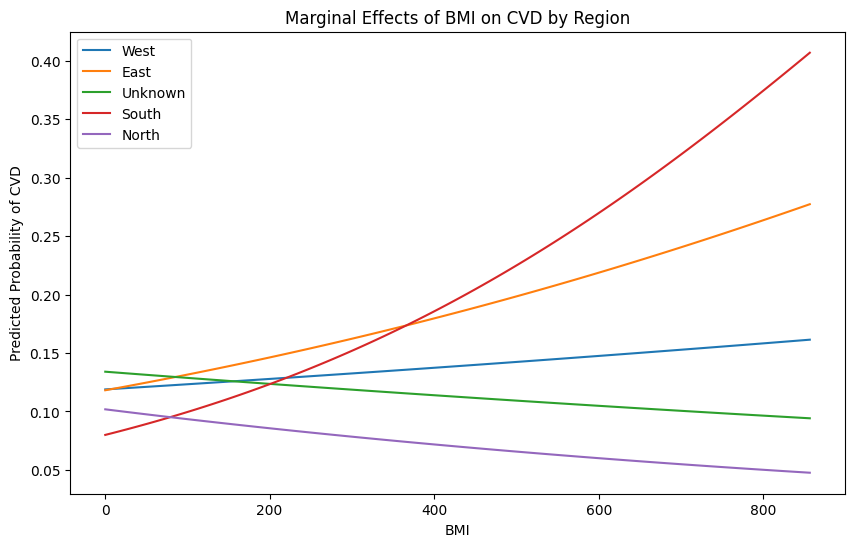

Marginal effects plot (Region x BMI) saved to marginal_effects_region_bmi.png


In [ ]:
# Marginal effects for Model 3 (Region x BMI)
bmi_range = np.linspace(df['BMI'].min(), df['BMI'].max(), 100)
regions = df['region'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Loop through each region and plot the marginal effect of BMI
for region in regions:
    new_data_region_bmi = pd.DataFrame({
        'BMI': bmi_range,
        'region': [region] * 100,  # Set region for all BMI values
        'agea': np.full(100, df['agea'].mean()),
        'gndr': np.full(100, df['gndr'].mean()),
        'cgtsmok': np.full(100, df['cgtsmok'].mean())  # Set to mean smoking level
    })

    pred_region_bmi = model3.predict(new_data_region_bmi)
    plt.plot(bmi_range, pred_region_bmi, label=region)

plt.xlabel('BMI')
plt.ylabel('Predicted Probability of CVD')
plt.title('Marginal Effects of BMI on CVD by Region')
plt.legend()
plt.savefig('marginal_effects_region_bmi.png')
plt.show()
print("Marginal effects plot (Region x BMI) saved to marginal_effects_region_bmi.png")


- This graph shows how Body Mass Index (BMI) relates to the risk of cardiovascular disease (CVD) across different regions. In the South, higher BMI strongly raises CVD risk, while in the East and West the increase is more moderate. Interestingly, in the North and Unknown regions, higher BMI is linked to a lower or slightly lower risk. In short, the impact of BMI on heart health appears to vary depending on where people live.


#  **Mediation**

In [ ]:
try:
    from causal_mediation import CausalMediation
    print("Causal mediation package is available.")
except ImportError:
    print("Causal mediation package not found. Skipping mediation analysis.")
    CausalMediation = None

if 'causal_mediation' in sys.modules:
    # Mediation: SES -> Smoking -> CVD
    # Here, SES is proxied by edulvl_high (high education level)
    # Mediator is cgtsmok (smoking)
    # Outcome is CVD
    mediation_model = CausalMediation(
        data=df,
        outcome='CVD',
        treatment='edulvl_high',
        mediator='cgtsmok',
        confounders=['agea', 'gndr', 'BMI', 'region']  # Adjust confounders as needed, including region
    )

    mediation_results = mediation_model.fit()

    # Print mediation results
    print("\n--- Mediation Analysis Results ---")
    print(mediation_results.summary())

Causal mediation package not found. Skipping mediation analysis.


# **Network Analysis**

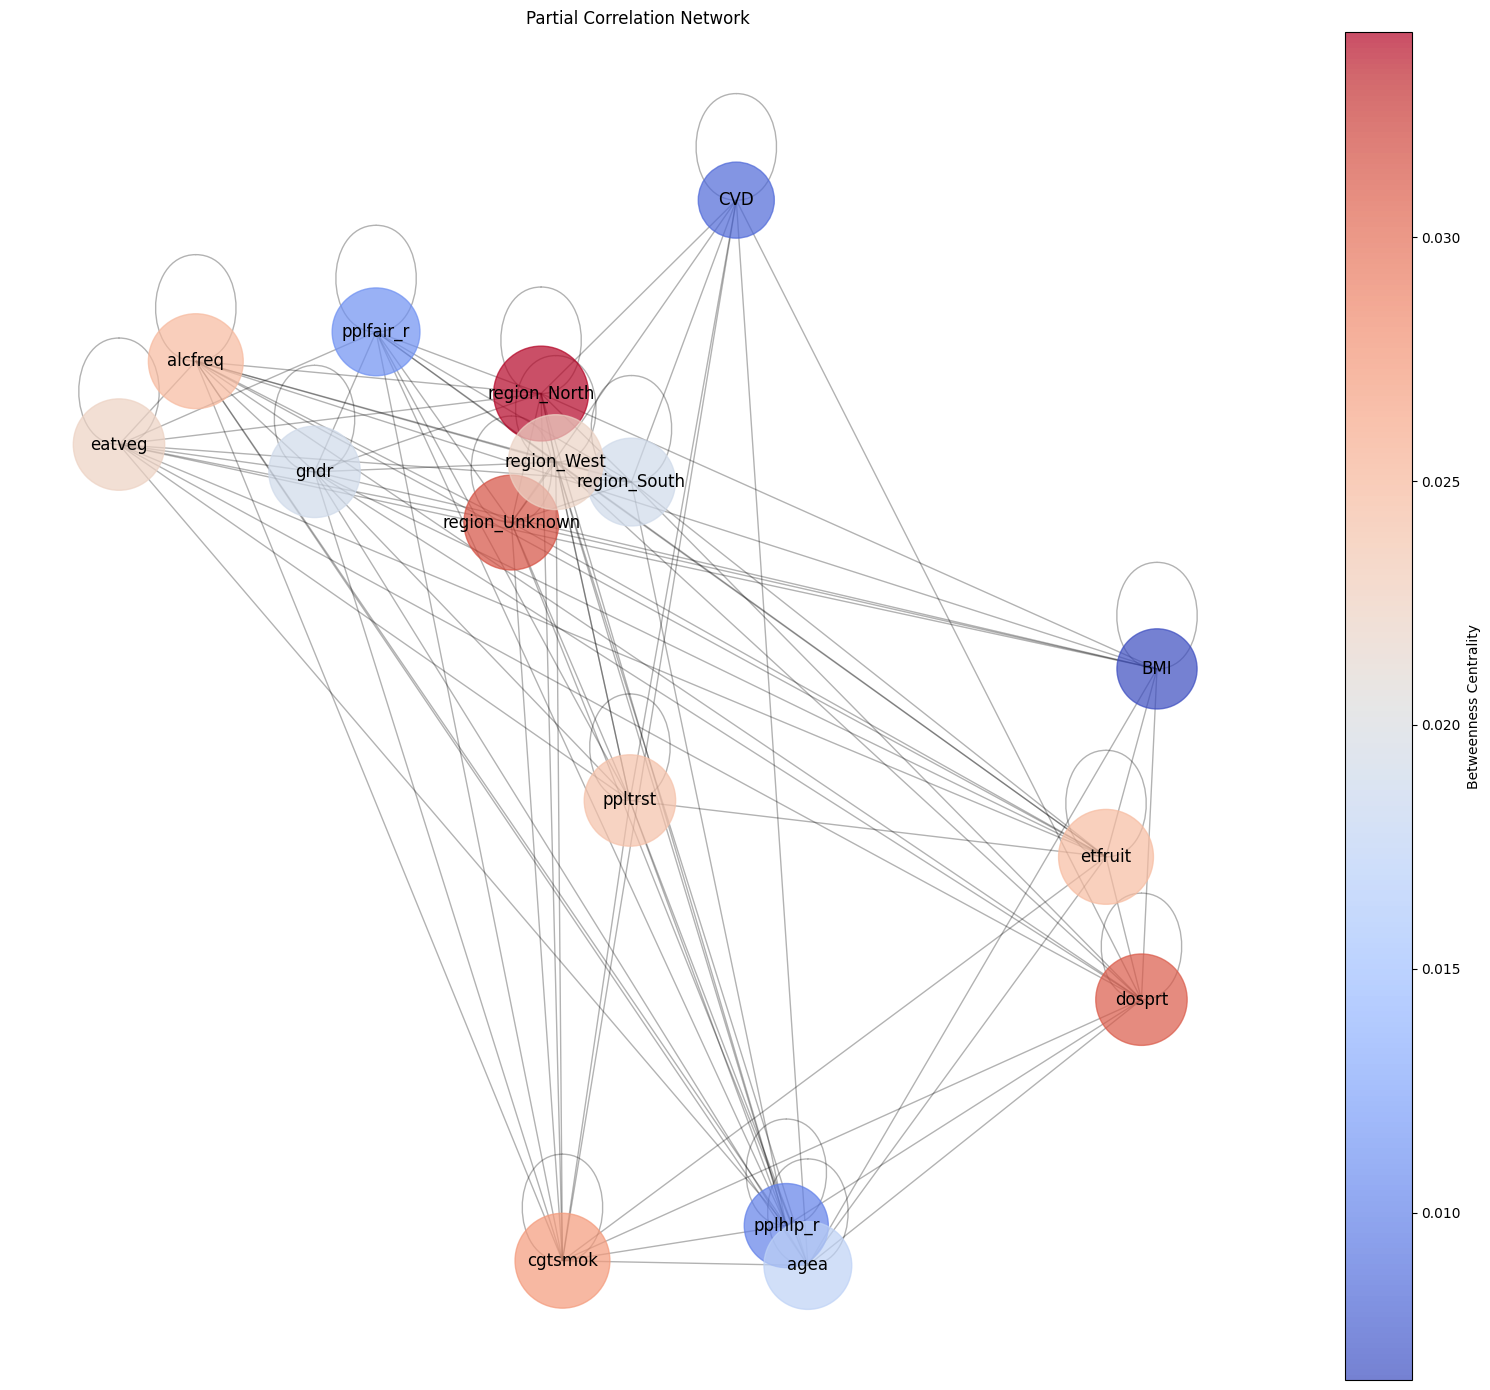

Network graph saved to fig_network.png


In [ ]:
from sklearn.covariance import GraphicalLassoCV

# Select variables for network analysis
network_vars = ['CVD', 'BMI', 'cgtsmok', 'alcfreq', 'etfruit', 'eatveg', 'dosprt',
                'ppltrst', 'pplfair_r', 'pplhlp_r', 'agea', 'gndr','region'] #added region

# One-Hot Encode 'region' for Network Analysis
df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)

# Update network_vars to include one-hot encoded region columns
network_vars_updated = network_vars[:-1]  # Exclude the original 'region' column
network_vars_updated.extend([col for col in df.columns if col.startswith('region_')])  # Add one-hot encoded columns

# Drop rows with missing values in the selected variables
network_data = df[network_vars_updated].dropna()

# Standardize the data
scaler = StandardScaler()
network_data_scaled = scaler.fit_transform(network_data)

# Estimate the precision matrix using GraphicalLassoCV
model = GraphicalLassoCV(cv=5, verbose=False, max_iter=500)
model.fit(network_data_scaled)
covariance = model.covariance_
precision = model.precision_

# Create the graph from the precision matrix
graph = nx.from_numpy_array(precision)

# Relabel nodes with variable names
mapping = {i: var for i, var in enumerate(network_vars_updated)}
graph = nx.relabel_nodes(graph, mapping)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

# Visualize the network with centrality as node size and color
plt.figure(figsize=(16, 14)) # Increased figure size for better readability
node_size = [v * 5000 for v in degree_centrality.values()]
node_color = [v for v in betweenness_centrality.values()]

pos = nx.spring_layout(graph, seed=42)  # You can try different layouts

nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.coolwarm, alpha=0.7) # Store the node object
nx.draw_networkx_edges(graph, pos, alpha=0.3)
nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')

plt.title("Partial Correlation Network")
plt.colorbar(nodes, label="Betweenness Centrality")
plt.axis('off')
plt.tight_layout()
plt.savefig('fig_network.png')
plt.show()
print("Network graph saved to fig_network.png")


- This network is like a roadmap of health and lifestyle factors, showing which ones are most connected and potentially influential in shaping CVD risk.


In [ ]:
# Print centrality measures
print("\n--- Centrality Measures ---")
print("\nDegree Centrality:", degree_centrality)
print("\nBetweenness Centrality:", betweenness_centrality)
print("\nEigenvector Centrality:", eigenvector_centrality)


--- Centrality Measures ---

Degree Centrality: {'CVD': 0.6, 'BMI': 0.6666666666666666, 'cgtsmok': 0.9333333333333333, 'alcfreq': 0.9333333333333333, 'etfruit': 0.9333333333333333, 'eatveg': 0.8666666666666667, 'dosprt': 0.8666666666666667, 'ppltrst': 0.8666666666666667, 'pplfair_r': 0.8, 'pplhlp_r': 0.7333333333333333, 'agea': 0.8, 'gndr': 0.8666666666666667, 'region_North': 0.9333333333333333, 'region_South': 0.8, 'region_Unknown': 0.9333333333333333, 'region_West': 0.9333333333333333}

Betweenness Centrality: {'CVD': 0.008333333333333333, 'BMI': 0.006572184429327287, 'cgtsmok': 0.027191987906273623, 'alcfreq': 0.024754346182917615, 'etfruit': 0.024633408919123204, 'eatveg': 0.022271352985638704, 'dosprt': 0.030982615268329548, 'ppltrst': 0.02409674981103552, 'pplfair_r': 0.011095993953136813, 'pplhlp_r': 0.009984882842025701, 'agea': 0.01738851095993953, 'gndr': 0.019040060468631898, 'region_North': 0.03419879062736206, 'region_South': 0.019070294784580506, 'region_Unknown': 0.0315

**What are Centrality Measures?**
- Centrality measures tell us which variables are most important in a network—like figuring out who the key players are in a social group.
 1. **Degree Centrality** – Counts how many direct links a variable has.
    - High degree = popular kids with lots of friends.
    - In this data: smoking, alcohol, eating fruit, and some regions are the most connected. CVD and BMI are less connected.
 2. **Betweenness Centrality** – Shows which variables act as bridges between others.
    - High betweenness = air traffic controllers keeping groups connected.
    - In this data: regions (North, Unknown) and doing sport are key connectors. CVD and BMI are not.
 2. **Eigenvector Centrality** – Captures influence by looking at connections to other important variables.
    - High eigenvector = trendsetters connected to other trendsetters.
    - In this data: region West, eating fruit, and alcohol frequency score highest.

**Overall:**
 - Some lifestyle and regional factors are well-connected, act as bridges, or influence other key variables. CVD and BMI play a role too, but more indirectly. Looking at all three measures together helps reveal the “power players” in the network.

